<a href="https://colab.research.google.com/github/Konerusudhir/machine_learning_exercises/blob/master/SemanticSearchV0_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Semantic Search on Arweave Images**

We fetch Arweave images and Index them using Faiss. Search is performed using Query embedding on the index. Below are the individual steps.

1.   Fetch Arweave Transactions containing images. 
2.   Fetch images corresponding to Transaction Ids from a Gateway using Graph QL. Parallell execution is used.
3.   Download Clip Model(openai/clip-vit-large-patch14) from HuggingFace and instantiate TextModel and VIsion Model.
4.   Create Index using Faiss
5.   Generate embeddings for images using Clip Model and them to index
6.   Query the index using Query string Text Model EMbeddings.
7.   Display search results.

## Acknowledgements
1. Search results in unintended images like NSFW images
2. This is setup is not evaluated using curated/benchmark dataset to verify
   accuracy
3. Index generation and Index search is not on GPU. Only Image embedding generation is in GPU
4. GPU Memory clean up is done manually. Need fine tuning to avoid OOM errors



In [1]:
%%capture
!pip install gql[all]
!pip install requests_toolbelt
!pip install transformers
!pip install faiss-gpu
!pip install torch
!pip install Pillow
!pip install matplotlib

In [2]:
import os
import shutil
import math 
import glob

from gql import Client, gql
from gql.transport.requests import RequestsHTTPTransport

import requests
from numpy import random
import numpy as np
import faiss

import torch

from PIL import Image
from IPython import display
import matplotlib.pyplot as plt

IMAGES_FOLDER = "./images"
GATEWAY_URL = "https://arweave-search.goldsky.com/graphql"
IMAGE_FETCH_HOST = "https://arweave.net"
MIN_BLOCK_ID = 1075311
MAX_BLOCK_ID = 1075331
QUERY_BATCH_SIZE = 100

RANDOM_SEED = 7

np.random.seed(RANDOM_SEED)

In [3]:
def clean_directories():
  shutil.rmtree(IMAGES_FOLDER, ignore_errors=True)

def create_directories():
  if not os.path.exists(IMAGES_FOLDER):
    os.mkdir(IMAGES_FOLDER) 

# clean_directories()
create_directories()

# 1 - Arweave Transactions Fetch

In [4]:
# Select your transport with a defined url endpoint
transport = RequestsHTTPTransport(
    url=GATEWAY_URL,
    verify=True,
    retries=3,
)

# Create a GraphQL client using the defined transport
client = Client(transport=transport, fetch_schema_from_transport=True)

image_tranasction_ids = []


def get_transaction_ids(min_block_id, max_block_id):
  gql_query_string = """
    # $cursor: ID!
    query (
      $min_block: Int!, 
      $max_block: Int!, 
      $query_batch_size: Int!, 
      $cursor: String!
    ) {
        transactions (
            block: { min: $min_block, max: $max_block },
            tags: {
                name: "Content-Type",
                values: ["image/png","image/jpeg", "image/gif"]
            },
            first: $query_batch_size,
            after: $cursor
        ) {
            edges {
                cursor
                node {
                    id
                }
            }
        }
    }
  """
  # Provide a GraphQL query
  query = gql(gql_query_string)

  for block_id in range(min_block_id, max_block_id):
    # Params

    cursor = ""
    while True:      
      params = {
          "min_block": block_id, 
          "max_block": block_id, 
          "query_batch_size": QUERY_BATCH_SIZE,
          "cursor": cursor
      }
      # Execute the query on the transport
      result = client.execute(query, variable_values=params)

      edges = result['transactions']['edges']

      for edge in edges:
        image_tranasction_ids.append(edge['node']['id'])
      print(f'Fetched {len(edges)} Images from Block {block_id}')  
      if len(edges) < QUERY_BATCH_SIZE:
        break
      cursor = edges[len(edges)-1]['cursor']
      

get_transaction_ids(MIN_BLOCK_ID, MAX_BLOCK_ID+1)

Fetched 6 Images from Block 1075311
Fetched 0 Images from Block 1075312
Fetched 32 Images from Block 1075313
Fetched 0 Images from Block 1075314
Fetched 2 Images from Block 1075315
Fetched 28 Images from Block 1075316
Fetched 0 Images from Block 1075317
Fetched 0 Images from Block 1075318
Fetched 11 Images from Block 1075319
Fetched 31 Images from Block 1075320
Fetched 96 Images from Block 1075321
Fetched 37 Images from Block 1075322
Fetched 0 Images from Block 1075323
Fetched 18 Images from Block 1075324
Fetched 10 Images from Block 1075325
Fetched 13 Images from Block 1075326
Fetched 10 Images from Block 1075327
Fetched 20 Images from Block 1075328
Fetched 1 Images from Block 1075329
Fetched 10 Images from Block 1075330
Fetched 20 Images from Block 1075331


# 2 - Fetch Images

In [5]:
%%time
from concurrent.futures import ThreadPoolExecutor
def fetch_image(img_transaction_id):

  img_url = f'{IMAGE_FETCH_HOST}/{img_transaction_id}'
  img_local_path = os.path.join(IMAGES_FOLDER,f"{img_transaction_id}.png")
  
  if not os.path.exists(img_local_path):    
    img = Image.open(requests.get(img_url, stream = True, timeout=5).raw)
    img.save(img_local_path)
  img_local_paths.append(img_local_path)  

  # return img_local_path

img_local_paths = []

with ThreadPoolExecutor(max_workers=8) as executor:
    executor.map(fetch_image, image_tranasction_ids)

downloaded_images_count = len(img_local_paths)
print(f"Downloaded {downloaded_images_count} Images")

Downloaded 343 Images
CPU times: user 1.67 s, sys: 1.33 s, total: 3 s
Wall time: 1min 45s


CPU times: user 430 ms, sys: 18.3 ms, total: 449 ms
Wall time: 477 ms


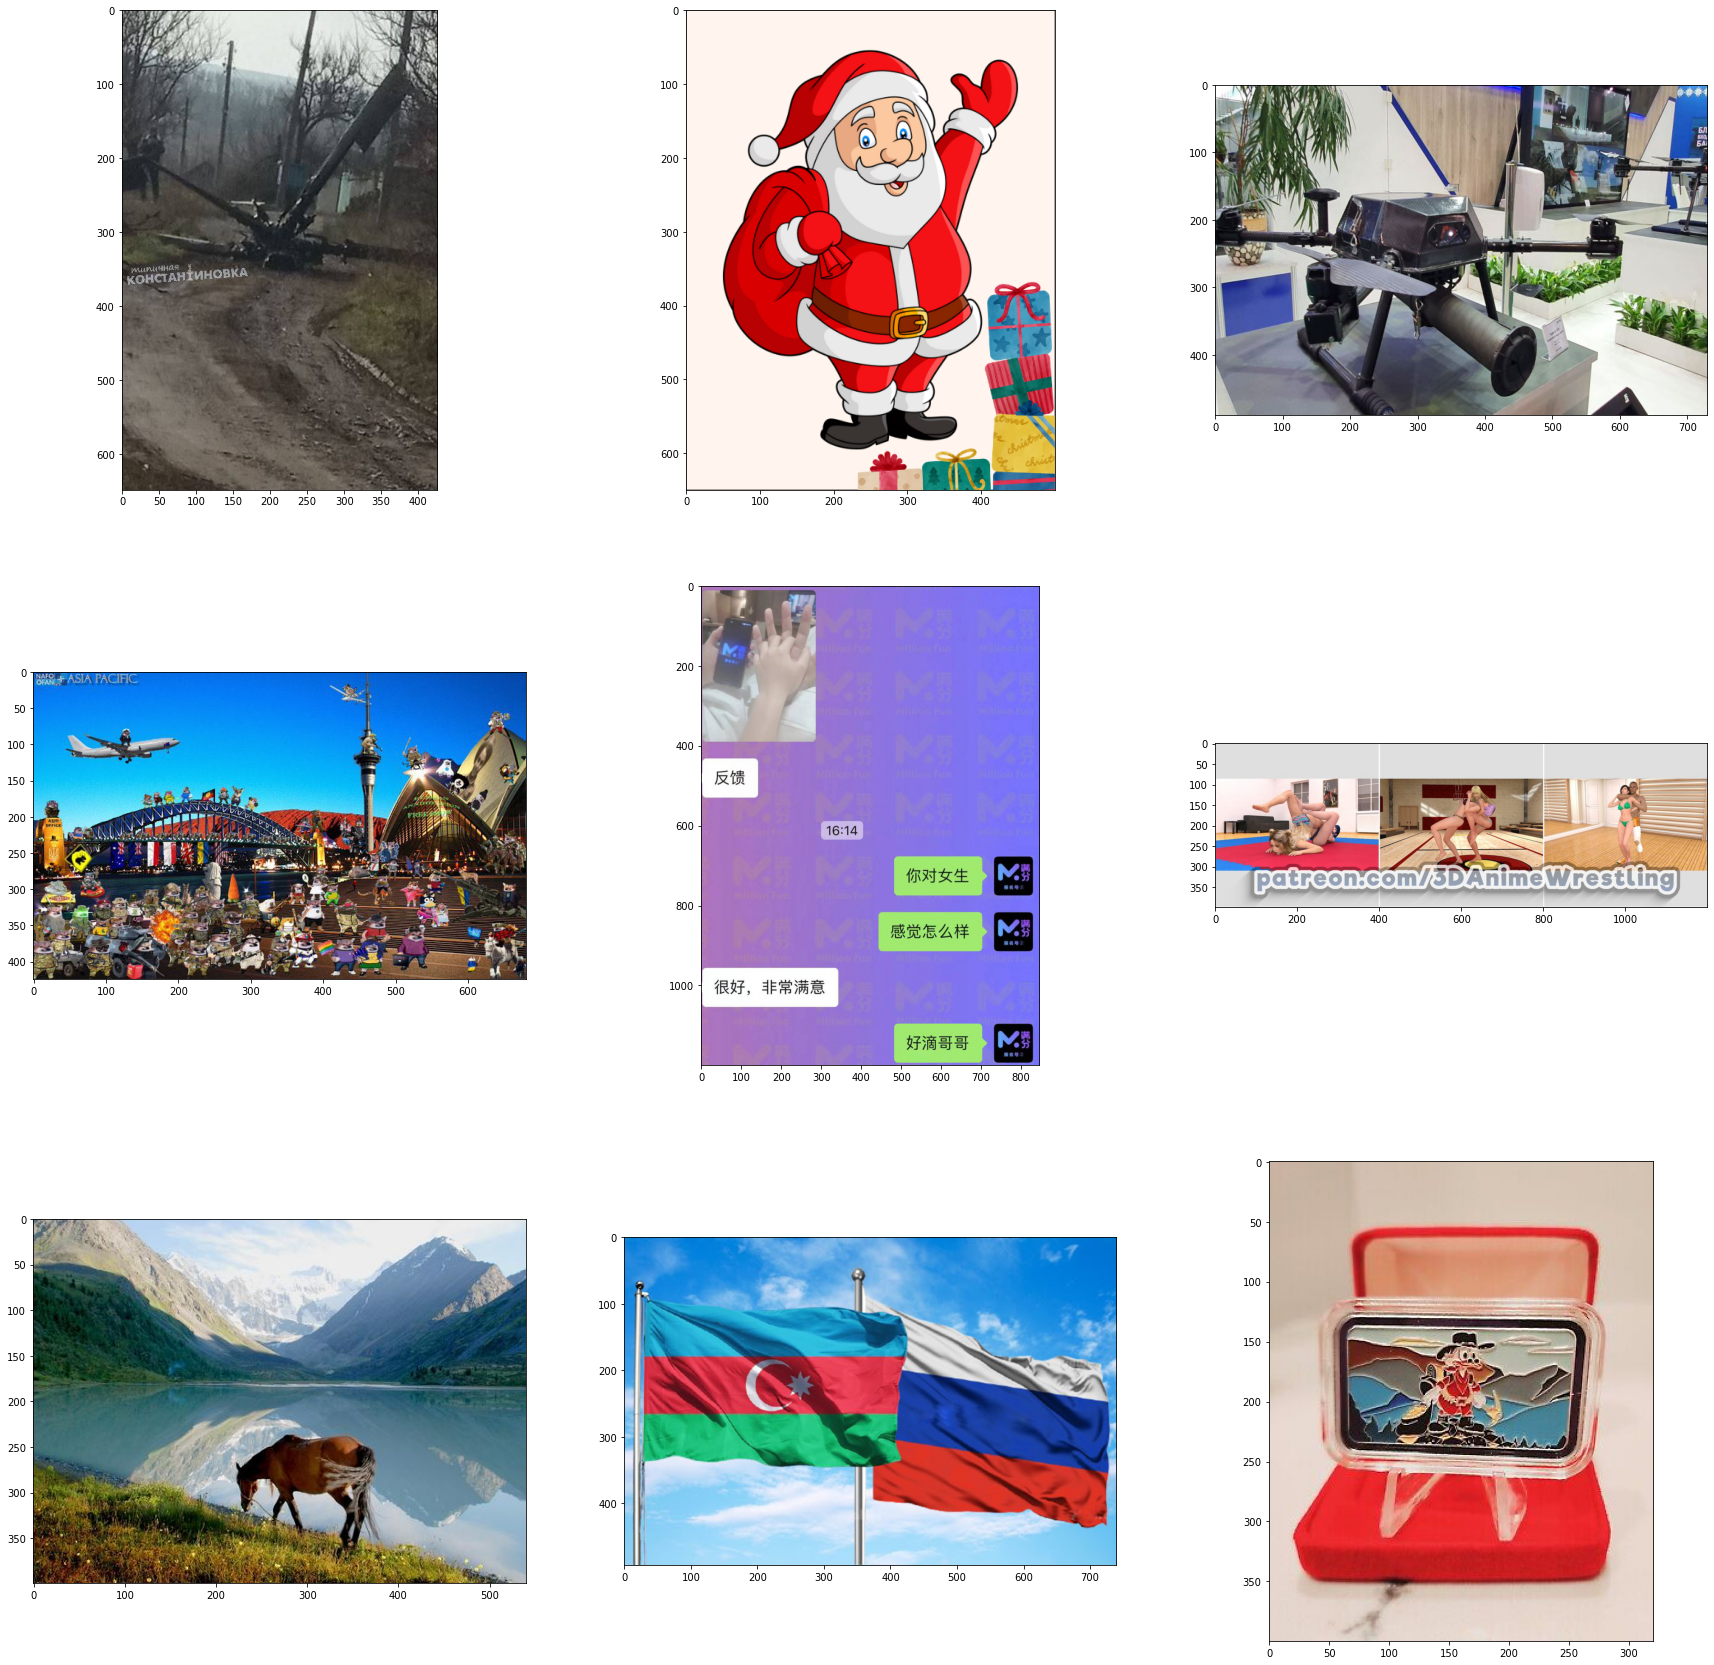

In [6]:
%%time
def img_reshape(img_path):
    img = Image.open(img_path).convert('RGB')
    # img = img.resize((300,300))
    img = np.asarray(img)
    return img

img_local_paths = []
for imagePath in os.listdir(IMAGES_FOLDER)[:9]:
  img_local_paths.append(os.path.join(IMAGES_FOLDER, imagePath))

rows=3
cols=3
img_count = 0

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(30,30))
# random_image_ids = random.randint(downloaded_images_count, size=(rows*cols))
for i in range(rows):
    for j in range(cols):        
        if img_count < len(img_local_paths):
            axes[i, j].imshow(img_reshape(img_local_paths[img_count]))
            img_count+=1

# 3 - Download Clip Model

In [7]:
%%time
from transformers import CLIPTokenizer, CLIPTextModelWithProjection, CLIPProcessor, CLIPVisionModelWithProjection, TFCLIPTextModel, TFCLIPVisionModel

DIMENSIONS = 768
clip_model_id = "openai/clip-vit-large-patch14"

text_model = CLIPTextModelWithProjection.from_pretrained(clip_model_id)
tokenizer = CLIPTokenizer.from_pretrained(clip_model_id)

vision_model = CLIPVisionModelWithProjection.from_pretrained(clip_model_id)
processor = CLIPProcessor.from_pretrained(clip_model_id)

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
vision_model.to(device)

Some weights of the model checkpoint at openai/clip-vit-large-patch14 were not used when initializing CLIPTextModelWithProjection: ['vision_model.encoder.layers.8.self_attn.out_proj.weight', 'vision_model.encoder.layers.2.layer_norm2.bias', 'vision_model.encoder.layers.5.self_attn.k_proj.bias', 'vision_model.encoder.layers.12.mlp.fc1.weight', 'vision_model.encoder.layers.0.mlp.fc2.weight', 'vision_model.encoder.layers.19.self_attn.out_proj.bias', 'vision_model.encoder.layers.9.self_attn.k_proj.weight', 'vision_model.encoder.layers.15.self_attn.v_proj.weight', 'vision_model.encoder.layers.11.self_attn.q_proj.weight', 'vision_model.encoder.layers.7.mlp.fc1.weight', 'vision_model.encoder.layers.7.self_attn.out_proj.weight', 'vision_model.encoder.layers.20.self_attn.out_proj.bias', 'vision_model.encoder.layers.0.layer_norm1.bias', 'vision_model.encoder.layers.16.layer_norm2.weight', 'vision_model.encoder.layers.4.mlp.fc1.bias', 'vision_model.encoder.layers.7.self_attn.k_proj.weight', 'visi

CPU times: user 10.6 s, sys: 5.7 s, total: 16.3 s
Wall time: 25.6 s


CLIPVisionModelWithProjection(
  (vision_model): CLIPVisionTransformer(
    (embeddings): CLIPVisionEmbeddings(
      (patch_embedding): Conv2d(3, 1024, kernel_size=(14, 14), stride=(14, 14), bias=False)
      (position_embedding): Embedding(257, 1024)
    )
    (pre_layrnorm): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
    (encoder): CLIPEncoder(
      (layers): ModuleList(
        (0): CLIPEncoderLayer(
          (self_attn): CLIPAttention(
            (k_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (v_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (q_proj): Linear(in_features=1024, out_features=1024, bias=True)
            (out_proj): Linear(in_features=1024, out_features=1024, bias=True)
          )
          (layer_norm1): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
          (mlp): CLIPMLP(
            (activation_fn): QuickGELUActivation()
            (fc1): Linear(in_features=1024, out_features=4096,

# 4 - Create Faiss Index

In [8]:
image_names = [name for name in os.listdir(IMAGES_FOLDER) if os.path.isfile(os.path.join(IMAGES_FOLDER, name))]
total_images_count = len(image_names)
storage = "Flat"
# cells = min(round(math.sqrt(total_images_count)), int(total_images_count/39))
cells = 5
# params = f"IVF{cells},{storage}"
params = f"IDMap,{storage}"
index = faiss.index_factory(DIMENSIONS, params)

print(f"Total Images: {total_images_count}  Clusters: {cells}")

Total Images: 343  Clusters: 5


In [9]:
def get_text_embeds(queries):
  inputs = tokenizer(queries, padding=True, return_tensors="pt")
  outputs = text_model(**inputs)
  return outputs.text_embeds.detach().numpy()

print(get_text_embeds(["a photo of a cat", "a photo of a dog"]).shape)

(2, 768)


# 5 - Index Images

In [10]:
%%time
image_ids_map = {}
image_embeds = None

with torch.no_grad():
    torch.cuda.empty_cache()

def get_embeds(images):
  inputs = processor(images=images, return_tensors="pt")
  inputs = inputs.to(device)
  outputs = vision_model(**inputs)
  return outputs.image_embeds #.detach().numpy()

def build_index():
  
  batch_size = 8
  image_batch = []
  image_ids = []
  first_batch = True
  for imagePath in os.listdir(IMAGES_FOLDER):
    
    inputPath = os.path.join(IMAGES_FOLDER, imagePath)    
    image_batch.append(img_reshape(inputPath))
    hash_value = hash(inputPath)
    image_ids.append(hash_value)
    image_ids_map[hash_value] = inputPath

    if len(image_batch) == batch_size:     
      image_embeds_batch = get_embeds(image_batch)
      print(image_embeds_batch.shape)
      image_embeds_batch = image_embeds_batch.to(torch.device("cpu"))        
      # if first_batch:
      # index.train(image_embeds_batch.detach().numpy())
      # first_batch = False

      index.add_with_ids(image_embeds_batch.detach().numpy(), np.array(image_ids))
      image_ids = []
      image_batch = []


image_embeds = build_index()


torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
torch.Size([8, 768])
CPU times: user 1min 20s, sys: 3.75 s, total: 1min 24s
Wall time: 1min 28s


# 6 - Query Index

In [12]:
searh_embeds = get_text_embeds(["cute, funny unicorn, doll, toy, bright"])
# searh_embeds = get_embeds(img_reshape(img_local_paths[0])).cpu().detach().numpy()
print(searh_embeds.shape)
# faiss.normalize_L2(searh_embeds)

probabilities, ids = index.search(searh_embeds, 16)
print(ids)
print(probabilities)


(1, 768)
[[-1209969005745907307  2338391183582870648  8023742905515702723
   6598875309673385325 -7632717472591429462 -5261067984937202537
  -3300498525670032362  7556679778632058369  2940116518753496292
  -7964150110923621706 -5273284348030025102  8596375112968095130
   6787964661534024312 -4399325169385549159  1544678646246591636
  -9106205376688847127]]
[[304.4925  361.19806 366.63205 367.77213 368.3017  379.4562  386.98877
  388.80862 390.78934 391.09967 394.6361  395.1013  395.84668 403.1709
  405.20978 407.4219 ]]


# 7 - Display Results

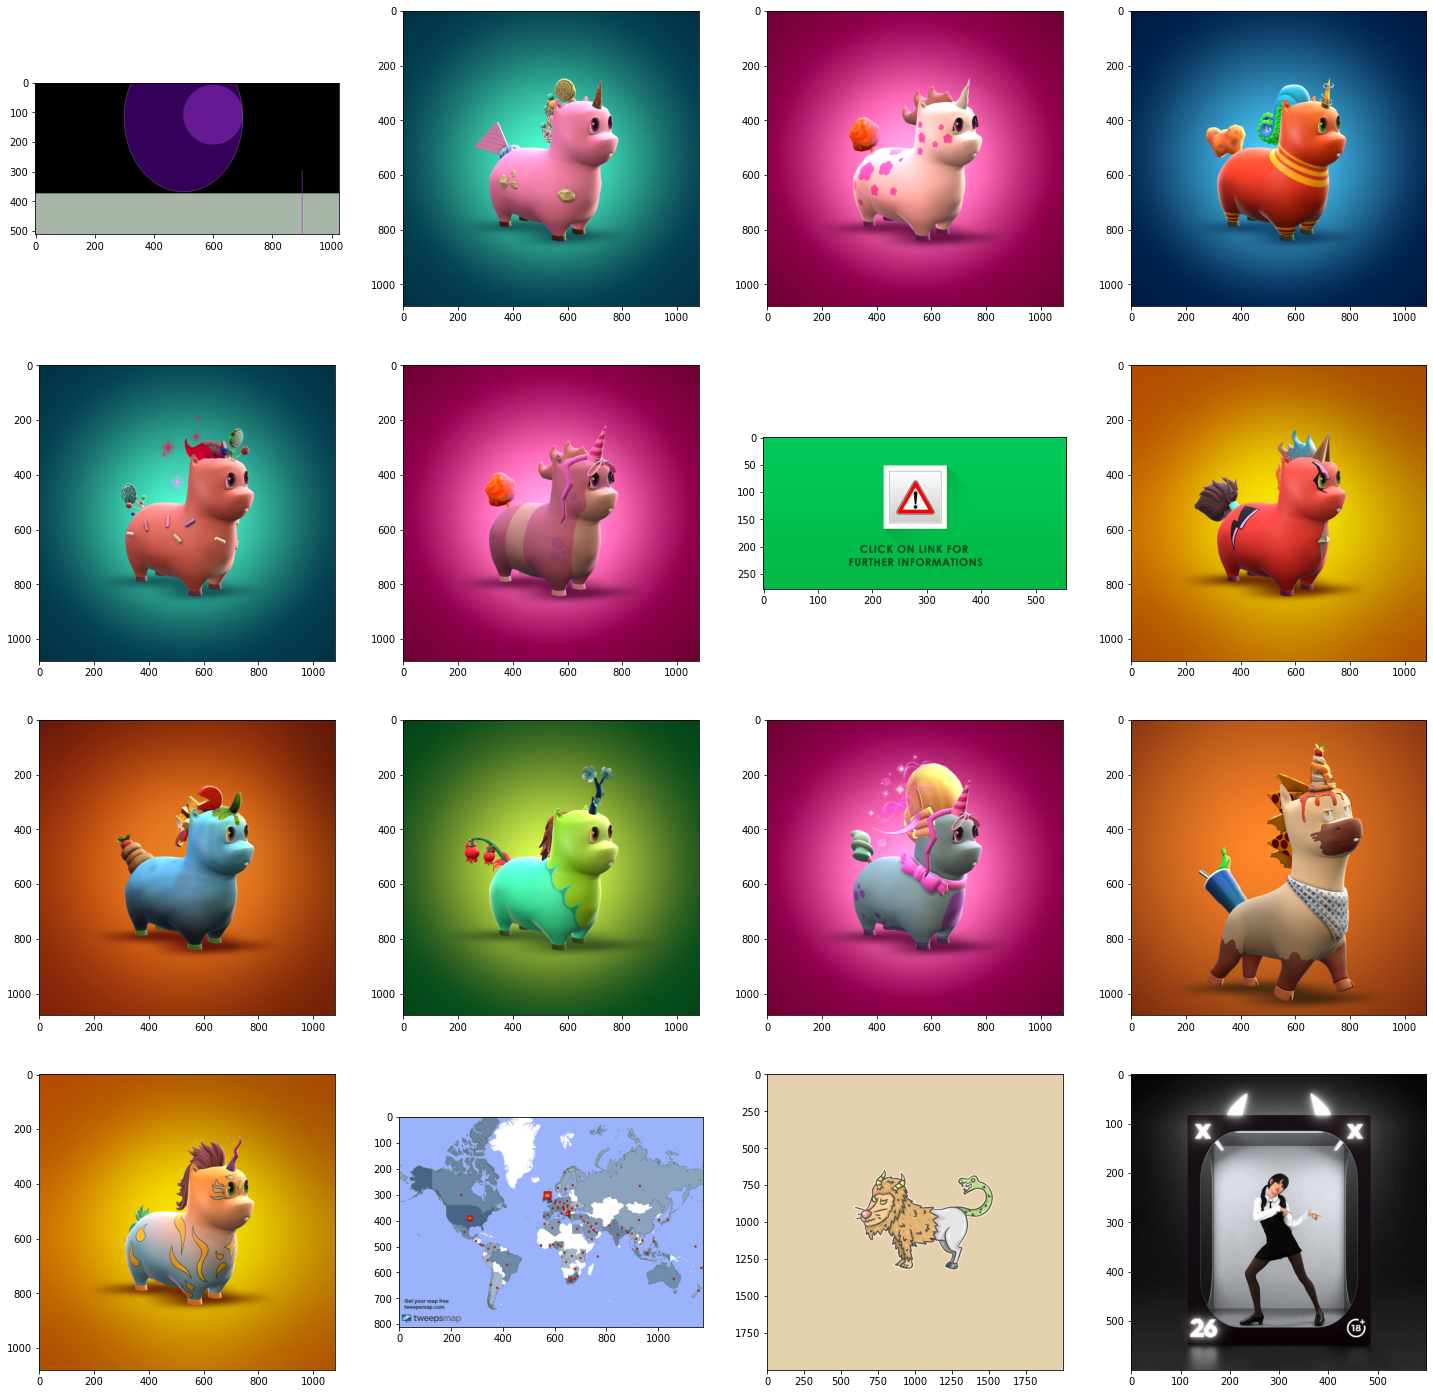

In [13]:
rows=4
cols=4
img_count = 0

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(25,25))
for i in range(rows):
    for j in range(cols):        
        if img_count < len(ids[0]):
            path = image_ids_map[ids[0][img_count]]
            axes[i, j].imshow(img_reshape(path))
            img_count+=1

In [14]:

torch.cuda.empty_cache()